# Ultrametric benchmark for continual learning - Artificial sequence - Data analysis
#### Simon Lebastard - 01/11/2020

First off let's go to the directory where the latest data was stored for artificial_8:

In [3]:
import os

#cwd = os.getcwd()
cwd = '/home/proprietaire/Documents/Workspace/Jobs/Columbia/ultrametric_benchmark/Ultrametric-benchmark'

In [6]:
dataset = 'artificial_8'
nnarchi = 'CNN'
seq_length = 100000
n_batch = 10

In [7]:
data_root = cwd + "/Results/" + dataset + '/' + nnarchi + '/length' + str(seq_length) + '_batches' + str(n_batch)
latest_save_folder = "T0.600_Memory0_block100_200112_01471578790020"

In [10]:
os.chdir(data_root + '/' + latest_save_folder)
os.listdir()

['autocorr_original.npy',
 'diagnostic_original.npy',
 'data_shuffle',
 'var_shuffle_accuracy.npy',
 'autocorr_shuffle.npy',
 'var_original_accuracy.npy',
 'shuffle',
 'var_original_classes_prediction.npy',
 'distribution_train',
 'train_data',
 'diagnostic_shuffle.npy',
 'parameters.npy',
 'var_shuffle_classes_prediction.npy',
 'original']

Now let's load standard packages and find out about the content of each file:

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pdb

import pickle

In [45]:
# train_data_orig
# Type: list    Stored as: pickle
# Contains the training data inputs, for the original training sequence
file = open('train_data', 'rb')
train_data_orig = pickle.load(file)
file.close()

# train_labels_orig
# Type: list    Stored as: pickle
# Contains the training labels, cast between 0 and N_labels, for the original training sequence
file = open('original', 'rb')
train_labels_orig = pickle.load(file)
file.close()

# train_data_shfl
# Type: list    Stored as: pickle
# Contains the training data inputs, for the shuffled training sequence
file = open('data_shuffle', 'rb')
train_data_shfl = pickle.load(file)
file.close()

# train_labels_shfl
# Type: list    Stored as: pickle
# Contains the training labels, cast between 0 and N_labels, for the shuffled training sequence
file = open('shuffle', 'rb')
train_labels_shfl = pickle.load(file)
file.close()

# distribution_train
# Type: list    Stored as: pickle
# Counts, for each label, the corresponding number of training example
file = open('distribution_train', 'rb')
dstr_train = pickle.load(file)
file.close()

# distribution_train
# Type: list    Stored as: pickle
# Counts, for each label, the corresponding number of training example
params = np.load('parameters.npy')

# autocorr_original.npy
# Type: array    Stored as: npy
# The autocorrelation function as computed by statsmodels.tsa.stattools.act
atc_orig = np.load('autocorr_original.npy')
# autocorr_shuffle.npy
# Type: array    Stored as: npy
# A list of autocorrelation functions, each computed on a different test sample, as computed by statsmodels.tsa.stattools.act
atc_shfl = np.load('autocorr_shuffle.npy')

# diagnostic_original.npy
# Type: array    Stored as: npy
# [0] contains the average accuracy split per level of hierarchy (I don't understand the split though)
# [1][0] contains the GT pointwise to the testing sequence
# [1][1] contains the prediction pointwise to the testing sequence
# [1][2:2+N_hier-1] contains the pointwise distance between GT and prediction on the testing sequence
eval_orig = np.load('diagnostic_original.npy', allow_pickle=True)
eval_shfl = np.load('diagnostic_shuffle.npy', allow_pickle=True)

# var_original_accuracy.npy
# Type: array    Stored as: npy
# [0] Average accuracy over full test sequence
# [1:test_nbr] Average accuracy over each test run
var_acc_orig = np.load('var_original_accuracy.npy')
var_acc_shfl = np.load('var_shuffle_accuracy.npy')

# var_original_classes_prediction.npy
# Type: array    Stored as: npy
# [0:test_nbr] Contains, for each test run, the composition of the test sampl,
# as well as the progress of training as the max training ID scanned at the time of the test run
var_pred_orig = np.load('var_original_classes_prediction.npy', allow_pickle=True)
var_pred_shfl = np.load('var_shuffle_classes_prediction.npy', allow_pickle=True)

Let's plot the autocorrelation function to DARPA standards:

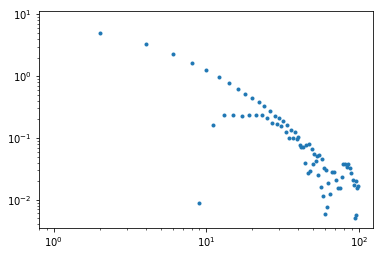

In [50]:
atc_plt_orig = plt.plot(atc_orig, marker='.', ls='none')
plt.xscale("log")
plt.yscale("log")